# train.py: What it does step by step

This tutorial will break down what train.py does when it is run, and illustrate the functionality of some of the custom 'utils' functions that are called during a training run, in a way that is easy to understand and follow.

Note that parts of the functionality of fc_train depend on the config.json file you are using. This tutorial is self-contained, and doesn't use a config file, but for more information on working with this file when using ProLoaF, see [this explainer](https://acs.pages.rwth-aachen.de/public/automation/plf/proloaf/docs/files-and-scripts/config/). Before proceeding to any of the sections below, please run the following code block:


In [1]:
import os
import sys    
import pandas as pd
import utils.datahandler as dh
import matplotlib.pyplot as plt
import numpy as np

## Table of contents:

[1. Dealing with missing values in the data](#1.-Dealing-with-missing-values-in-the-data)

[2. Selecting and scaling features](#2.-Selecting-and-scaling-features)

[3. Creating a dataframe to log training results](#3.-Creating-a-dataframe-to-log-training-results)

[4. Exploration](#4.-Exploration)

[5. Main run - creating the training model](#5.-Main-run---creating-the-training-model)

[6. Main run - training the model](#6.-Main-run---training-the-model)

[7. Updating the config](#7.-Updating-the-config)

[8. Saving the model & logs](#8.-Saving-the-model-&-logs)

[9. Using fc_train](TODO: create section, add link)



## 1. Dealing with missing values in the data

The first thing fc_train does after loading the dataset that was specified in your config file, is to check for any missing values, and fill them in as necessary. It does this using the function 'utils.datatuner.fill_if_missing'. In the following example, we will load some data that has missing values and examine what the 'fill_if_missing' function does. Please run the code block below to get started.

<AxesSubplot:>

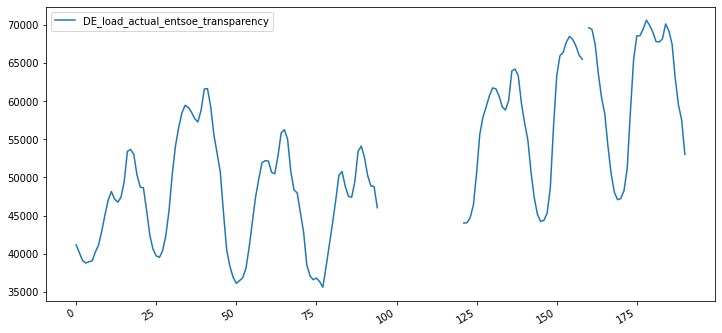

In [2]:
#Load the data sample and prep for use with datatuner functions
df = pd.read_csv("../data/fill_missing.csv", sep=";")
df['Time'] = pd.to_datetime(df['Time'])
df = df.set_index('Time')
df = df.astype(float)
df_missing_range = df.copy()

#Plot the data
df.iloc[0:192].plot(kind='line',y='DE_load_actual_entsoe_transparency', figsize = (12, 6), xlabel='Hours', use_index = False)

As should be clearly visible in the plot above, the data has some missing values. There is a missing range (a range refers to multiple adjacent values), from around 96-121, as well as two individual values that are missing, at 160 and 192. Please run the code block below to see how 'fill_if_missing' deals with these problems.

Some values are NaN. They are being filled...
...interpolation finished! No missing data left.


<AxesSubplot:>

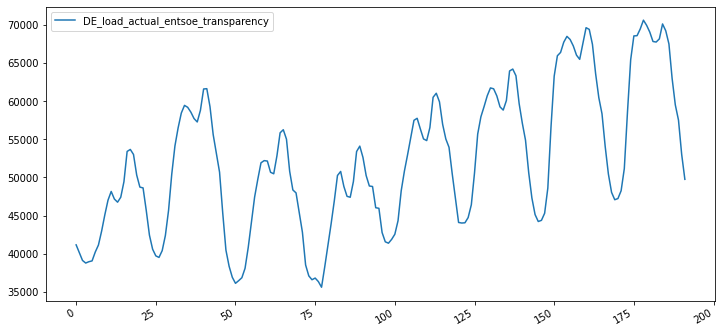

In [3]:
#Use fill_if_missing and plot the results
dh.fill_if_missing(df, periodicity=24)
df.iloc[0:192].plot(kind='line',y='DE_load_actual_entsoe_transparency', figsize = (12, 6), use_index = False)

As we can see by the printed console messages, fill_if_missing first checks whether there are any missing values. If there are, it checks whether they are individual values or ranges, and handles these cases differently: 

### Single missing values:
These are simply replaced by the average of the values on either side.

### Missing range:
For each missing value in the range at a given position t, fill_if_missing first searches backwards through the data at intervals equal to the periodicity of the data - 24 hours by default (i.e. t1 = t - 24\*n, n = 1, 2, ...) until it finds an existing value. It then does the same thing searching forwards through the data (i.e. t2 = t + 24\*n, n = 1, 2, ...), and then it sets the value at t equal to the average of t1 and t2. Run the code block below to see the result for the missing range at 96-121:

<AxesSubplot:>

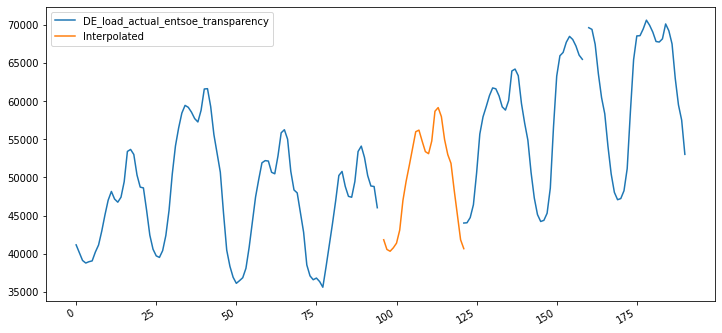

In [4]:
start = 96
end = 121
seas = np.zeros(len(df_missing_range))

#fill the missing values
for t in range(start, end + 1):
    p1 = 24
    p2 = 24
    while np.isnan(df_missing_range.iloc[t - p1, 0]):
        p1 += 24
    while np.isnan(df_missing_range.iloc[t + p2, 0]):
        p2 += 24

    seas[t] = (df_missing_range.iloc[t - p1, 0] + df_missing_range.iloc[t + p2, 0]) / 2

#plot the result
ax = plt.gca()
df_missing_range["Interpolated"] = pd.Series(len(seas))
for t in range(start, end + 1):
    df_missing_range.iloc[t, 1] = seas[t]
df_missing_range.iloc[0:192].plot(kind='line',y='DE_load_actual_entsoe_transparency', figsize = (12, 6), use_index = False, ax = ax)
df_missing_range.iloc[0:192].plot(kind='line',y='Interpolated', figsize = (12, 6), use_index = False, ax = ax)

The missing values in the range between 96 and 121 have now been filled in, but the end points aren't continuous with the original data, and the new values don't take into account the (in this case, downward) trend in the data. To deal with this, the function uses the difference in slope between the start and end points of the missing data range, and the start and end points of the newly interpolated values, to offset the new values so that they line up with the original data:

Create two straight lines that connect the interpolated start and end points, and the original start and end points.
These capture the 'trend' in each case over the missing section


<AxesSubplot:>

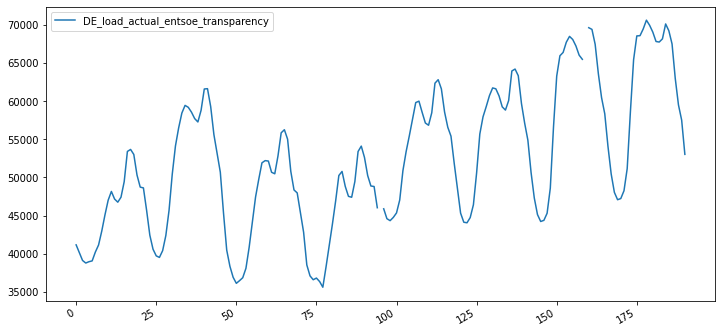

In [5]:
print("Create two straight lines that connect the interpolated start and end points, and the original start and end points.\nThese capture the 'trend' in each case over the missing section")
trend1 = np.poly1d(
    np.polyfit([start, end], [seas[start], seas[end]], 1)
)
trend2 = np.poly1d(
    np.polyfit(
        [start - 2, end + 1],
        [df_missing_range.iloc[start - 2, 0], df_missing_range.iloc[end + 1, 0]],
        1,
    )
)

#by subtracting the trend of the interpolated data, then adding the trend of the original data, we match the filled in
#values to what we had before
for t in range(start, end + 1):
    df_missing_range.iloc[t, 0] = seas[t] - trend1(t) + trend2(t)
    
#plot the result
ax = plt.gca()
df_missing_range.iloc[0:192].plot(kind='line',y='DE_load_actual_entsoe_transparency', figsize = (12, 6), use_index = False, ax = ax)

**Please note:**
- fill_if_missing assumes a periodicity. Per defautlt it is set to 1 time step. In the above example we haved defined the periodicity to be equal to 24.
- Missing data ranges at the beginning or end of the data are handled differently (TODO: Explain how)
- Though the examples shown here use a single column for simplicity's sake, fill_if_missing automatically works on every column of your original dataframe. 

## 2. Selecting and scaling features

The next thing train.py does is to select and scale features in the data as specified in the relevant config file, using the function 'utils.datahandler.scale_all'.

Consider the following dataset:

,AT_load_actual_entsoe_transparency,DE_load_actual_entsoe_transparency,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal,hour_sin,hour_cos,...,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
Time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00,5946.0,41151.0,-6.495,0.0,0.0,-0.940,0.0,0.0,-0.258819,0.965926,...,0,0,1,0,0,1,0,0,0,0
2015-01-01 00:00:00,5946.0,41151.0,-6.503,0.0,0.0,-0.981,0.0,0.0,0.000000,1.000000,...,0,0,0,0,0,0,1,0,0,0
2015-01-01 01:00:00,5726.0,40135.0,-6.458,0.0,0.0,-1.035,0.0,0.0,0.258819,0.965926,...,0,0,0,0,0,0,1,0,0,0
2015-01-01 02:00:00,5347.0,39106.0,-6.253,0.0,0.0,-1.109,0.0,0.0,0.500000,0.866025,...,0,0,0,0,0,0,1,0,0,0
2015-01-01 03:00:00,5249.0,38765.0,-5.908,0.0,0.0,-1.166,0.0,0.0,0.707107,0.707107,...,0,0,0,0,0,0,1,0,0,0


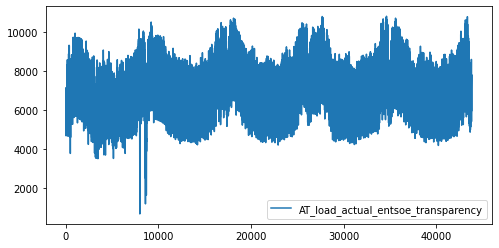

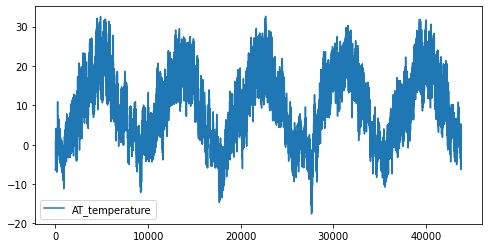

In [6]:
#Load and then plot the new dataset
df_to_scale = pd.read_csv("../data/opsd.csv", sep=";", index_col=0)

df_to_scale.plot(kind='line',y='AT_load_actual_entsoe_transparency', figsize = (8, 4), use_index = False)
df_to_scale.plot(kind='line',y='AT_temperature', figsize = (8, 4), use_index = False)
df_to_scale.head()

The above dataset has 55 features (columns), some of which are at totally different scales, as is clearly visible when looking at the y-axes of the above graphs for load and temperature data from Austria. 

Depending on our dataset, we may not want to use all of the available features for training. 
If we wanted to select only the two features highlighted above for training, we could do so by editing the value at the "feature_groups" key in the config.json, which takes the form of a list of dicts like the one below:

In [7]:
two_features = [
    {
        "name": "main",
        "scaler": [
            "minmax",
            -1.0,
            1.0
        ],
        "features": [
            "AT_load_actual_entsoe_transparency",
            "AT_temperature"
        ]
    }
]

Each dict in the list represents a feature group, and should have the following keys:
- "name" - the name of the feature group
- "scaler" - the scaler used by this feature group (value: a list with entries for scaler name and scaler specific attributes.) Valid scaler names include 'standard', 'robust' or 'minmax'. For more information on these scalers and their use, please see the [scikit-learn documentation](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing) or [the documentation for scale_all](https://acs.pages.rwth-aachen.de/public/automation/plf/proloaf/reference/proloaf/proloaf/utils/datahandler.html#scale_all)
- "features" - which features are to be included in the group (value: a list containing the feature names)

The 'scale_all' function will only return the selected features, scaled using the scaler assigned to their feature group.
Here we only have one group, 'main', which uses the 'minmax' scaler:

Currently used scalers:
{'main': MinMaxScaler(feature_range=(-1.0, 1.0))}


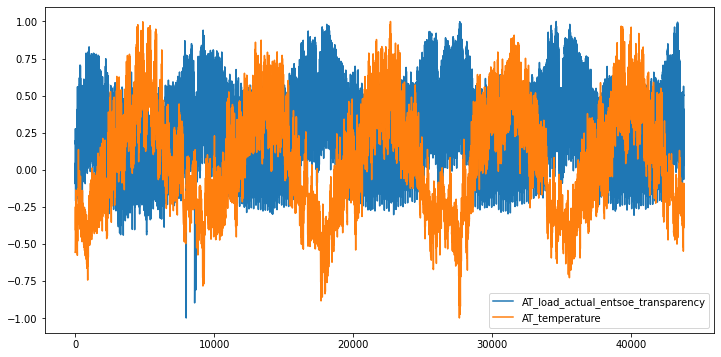

In [8]:
#Select, scale and plot the features as specified by the two_features list (see above)
selected_features, scalers = dh.scale_all(df_to_scale, two_features)
selected_features.plot(figsize = (12, 6), use_index = False)
print("Currently used scalers:")
print(scalers)

As you can see, both of our features (load and temperature for Austria) have now been scaled to fit within the same range (between -1 and 1).

Let's say we also wanted to include the weekday data from the data set in our training. Let us first take a look at what the weekday features look like. Here are the first 500 hours (approx. 3 weeks) of weekday_0:

<AxesSubplot:>

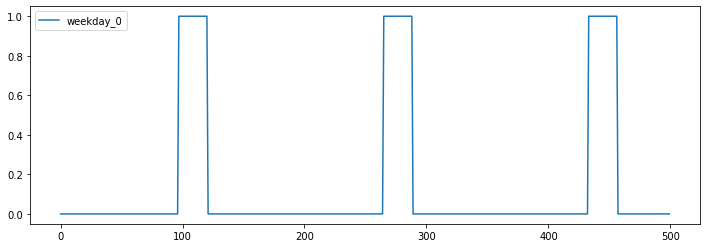

In [9]:
df_to_scale[:500].plot(kind='line',y='weekday_0', figsize = (12, 4), use_index = False)

As we can see, these features are already within the range [0,1] and thus don't need to be scaled. So we can include them in a second feature group called 'aux'. Note, features which we deliberately aren't scaling should go in a group with this name.

The value of the "feature_groups" key in the config.json could then look like this:

In [10]:
feature_groups = [
    {
        "name": "main",
        "scaler": [
            "minmax",
            0.0,
            1.0
        ],
        "features": [
            "AT_load_actual_entsoe_transparency",
            "AT_temperature"
        ]
    },
    {
        "name": "aux",
        "scaler": None,
        "features": [
            "weekday_0",
            "weekday_1",
            "weekday_2",
            "weekday_3",
            "weekday_4",
            "weekday_5",
            "weekday_6"
        ]
    }
]

We now have two feature groups, 'main' (which uses the 'minmax' scaler, this time with a range between 0 and 1) and 'aux' (which uses no scaler):

Currently used scalers:
{'main': MinMaxScaler(feature_range=(0.0, 1.0)), 'aux': None}


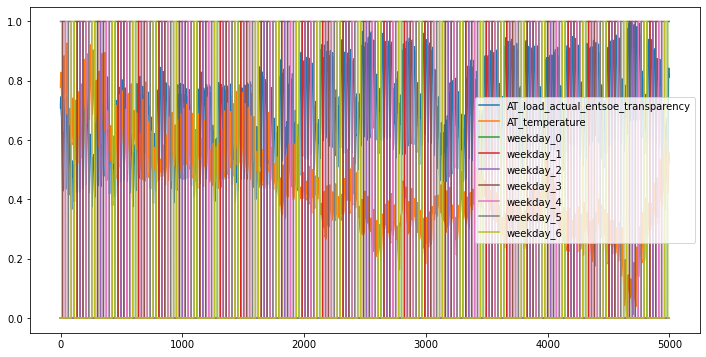

In [11]:
#Select, scale and plot the features as specified by feature_groups (see above)
selected_features, scalers = dh.scale_all(df_to_scale,feature_groups)
selected_features[23000:28000].plot(figsize = (12, 6), use_index = False)
print("Currently used scalers:")
print(scalers)

We can see that all of our selected features now fit between 0 and 1.

<AxesSubplot:ylabel='Density'>

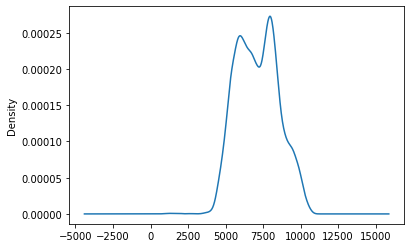

In [12]:
#df_to_scale.at["AT_load_actual_entsoe_transparency", 300] = 15000
#TODO: expand here...
df_to_scale["AT_load_actual_entsoe_transparency"].plot.kde()

From this point onward, train.py will only work with our selected, scaled features.

In [13]:
print("Currently selected and scaled features: ")
print(selected_features.columns)

Currently selected and scaled features: 
Index(['AT_load_actual_entsoe_transparency', 'AT_temperature', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6'],
      dtype='object')


## 3. Creating a dataframe to log training results

Having already filled any missing values in our data, and scaled and selected the features we want to use for training,
at this point we use the function 'utils.loghandler.create_log' to create a dataframe which will log the results of our training. 

This dataframe is saved as a .csv file at the end of the main training run. This allows different training runs, e.g. using new data or different parameters, to be compared with one another, so that we can monitor any changes in performance and compare the most recent run to the best performance achieved so far.

'create_log' creates the dataframe by getting which features we'll be logging from the [log.json file](https://acs.pages.rwth-aachen.de/public/automation/plf/proloaf/docs/files-and-scripts/log/), and then:
- loading an existing log file (from MAIN_PATH/\<log_path\>/\<model_name\>/\<model_name\>+"_training.csv" - see the [config.json explainer](https://acs.pages.rwth-aachen.de/public/automation/plf/proloaf/docs/files-and-scripts/config/) for more information) 
- or creating a new dataframe from scratch, with the required features.

The newly created dataframe, log_df, is used at various later points in fc_train (see sections [4](#4.-Exploration), [6](#6.-Main-run---training-the-model) and [8](#8.-Saving-the-model-&-logs) for more info).

## 4. Exploration

From this point on, it is assumed that we are working with prepared and scaled data (see earlier sections for more details).

The exploration phase is optional, and will only be carried out if the 'exploration' key in the config.json file is set to 'true'. The purpose of exploration is to tune our hyperparameters before the main training run. This is done by using [Optuna](https://optuna.org/) to optimize our [objective function](#Objective-function). Optuna iterates through a number of trials - either a fixed number, or until timeout (as specified in the tuning.json file, [see below](#tuning.json) for more info) - with the purpose of finding the hyperparameter settings that result in the smallest validation loss. This is an indicator of the quality of the prediction - the validation loss is the discrepancy between the predicted values and the actual values (targets) from the validation dataset, as determined by one of the metrics from [utils.metrics](https://acs.pages.rwth-aachen.de/public/automation/plf/proloaf/reference/proloaf/proloaf/utils/eval_metrics.html). The metric used is specified when fc_train is called. (TODO See section 9...)

Once Optuna is done iterating, a summary of the trials is printed (number of trials, details of the best trial), and if the new best trial represents an improvement over the previously logged best, you will be prompted about whether you would like to overwrite the config.json with the newly found hyperparameters, so that they can be used for future training. 

Optuna also has built-in paralellization, which we can opt to use by setting the 'parallel_jobs' key in the config.json to 'true'.

### Objective function
The previously mentioned objective function is a callable which Optuna uses for its optimization. In our case, it is the function 'fc_train.objective', which does the following per trial:
- Suggests values for each hyperparameter as per the [tuning.json](#tuning.json)
- Creates (see [section 5](#5.-Main-run---creating-the-training-model)) and trains (see  [section 6](#6.-Main-run---training-the-model)) a model using these hyperparameters and our selected features and scalers 
- Returns a score for the model in the form of the validation loss after training.

### tuning.json
The tuning.json file ([see explainer](https://acs.pages.rwth-aachen.de/public/automation/plf/proloaf/docs/files-and-scripts/config/#tuning-config) is located in the same folder as the other configs, under proloaf/targets/\<model name\>, and contains information about the hyperparameters to be tuned, as well as settings that limit how long Optuna should run. It can look like this, for example:

```json
{
  "number_of_tests": 100,
  "settings": 
  {
      "learning_rate": {
          "function": "suggest_loguniform",
          "kwargs": {
              "name": "learning_rate",
              "low": 0.000001,
              "high": 0.0001
          }
      },
      "batch_size": {
          "function": "suggest_int",
          "kwargs": {
              "name": "batch_size",
              "low": 32,
              "high": 120
          }
     }
  }
}
```
- "number_of_tests": 100 here means that Optuna will stop after 100 trials. Alternatively, "timeout": \<number in seconds\> would limit the maximum duration for which Optuna would run. If both are specified, Optuna will stop whenever the first criterion is met. If neither are specified, Optuna will wait for a termination signal (Ctrl+C or SIGTERM).

- The "settings" keyword has a dictionary as its value. This dictionary contains keywords for each of the hyperparameters that Optuna is to optimize, e.g. "learning_rate", "batch_size". 

- Each hyperparameter keyword takes yet another dictionary as a value, with the keywords "function" and "kwargs"

  - "function" takes as its value a function name beginning with "suggest_..." as described in the [Optuna docs](https://optuna.readthedocs.io/en/v1.4.0/reference/trial.html#optuna.trial.Trial.suggest_loguniform). These "suggest" functions are used to suggest hyperparameter values by sampling from a range with the relevant distribution.
  
  - "kwargs" has keywords for the arguments required by the "suggest" functions, typically "low" and "high" for the start and endpoints of the desired ranges as well as a "name" keyword which stores the hyperparameter name. 

### Notes
- When running fc_train using Gitlab CI, the prompt about whether to overwrite the config.json with the newly found values  is disabled (as well as all other similar prompts).
- Though the objective function takes log_df (from the previous section) as a parameter, as it is required by the 'train' function, none of the training runs from this exploration phase are actually logged. Only the main run is logged. (See the next section for more)

## 5. Main run - creating the training model

Now that the data is prepared, the features are selected, and the (optional) hyperparameter exploration is done, train.py will begin the main run, by creating the model that will be used for the training.

This is done using the function ['make_model'](https://acs.pages.rwth-aachen.de/public/automation/plf/proloaf/reference/proloaf/proloaf/source/train.html#make_model). This function takes our selected features and scalers, as well as several other parameters from the config.json, and returns four things: TODO: continue from this point...
- a model ready for training...
- a CustomTensorDataLoader* for the training data...
- a CustomTensorDataLoader* for the validation data...
- a CustomTensorDataLoader* for the testing data...

\*CustomTensorDataLoader is a custom structure...

Essentially, these are the parameters required by the 'train' function in the next section. 
Especially of note is that at this point, fc_train transitions from using the dataframe with our selected features to using three separate tensors, with a transformed structure, for training, validation, and testing respectively. 

This is the by now familiar structure of the selected features Dataframe:

In [14]:
#selected_features.head()
selected_features

,AT_load_actual_entsoe_transparency,AT_temperature,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
Time,,,,,,,,,
2014-12-31 23:00:00,0.520959,0.221017,0,0,1,0,0,0,0
2015-01-01 00:00:00,0.520959,0.220857,0,0,0,1,0,0,0
2015-01-01 01:00:00,0.499260,0.221753,0,0,0,1,0,0,0
2015-01-01 02:00:00,0.461880,0.225835,0,0,0,1,0,0,0
2015-01-01 03:00:00,0.452214,0.232704,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,0.600059,0.322735,0,1,0,0,0,0,0
2019-12-31 20:00:00,0.568597,0.317260,0,1,0,0,0,0,0
2019-12-31 21:00:00,0.574810,0.310789,0,1,0,0,0,0,0


In [15]:
history_horizon = 25
forecast_horizon = 50
encoder_features = [
        "AT_load_actual_entsoe_transparency",
        "AT_temperature"
    ]
x_enc = dh.extract(selected_features[encoder_features].iloc[:-forecast_horizon, :], history_horizon)
print(x_enc[0][0])
print(x_enc[1])
print(x_enc[2])
a = np.array(x_enc)
a.shape

[0.52095867 0.22101658]
[[0.52095867 0.22085731]
 [0.49926028 0.22175324]
 [0.46187987 0.22583471]
 [0.45221422 0.23270353]
 [0.45813197 0.24050809]
 [0.48426867 0.24783483]
 [0.51888746 0.25394708]
 [0.56011441 0.26712724]
 [0.61327547 0.29444323]
 [0.62126442 0.32414837]
 [0.6357629  0.34931411]
 [0.63832725 0.36607801]
 [0.62619588 0.37489796]
 [0.598777   0.3739423 ]
 [0.57984022 0.35948792]
 [0.58575796 0.33866247]
 [0.598777   0.32156012]
 [0.58802643 0.31291935]
 [0.59907289 0.30575189]
 [0.59078805 0.30302427]
 [0.55143505 0.29954009]
 [0.54808166 0.29579708]
 [0.51287109 0.296255  ]
 [0.48022487 0.29858443]
 [0.44787454 0.3028849 ]]
[[0.49926028 0.22175324]
 [0.46187987 0.22583471]
 [0.45221422 0.23270353]
 [0.45813197 0.24050809]
 [0.48426867 0.24783483]
 [0.51888746 0.25394708]
 [0.56011441 0.26712724]
 [0.61327547 0.29444323]
 [0.62126442 0.32414837]
 [0.6357629  0.34931411]
 [0.63832725 0.36607801]
 [0.62619588 0.37489796]
 [0.598777   0.3739423 ]
 [0.57984022 0.35948792]


(43751, 25, 2)

## 6. Main run - training the model

## 7. Updating the config

## 8. Saving the model & logs